## Data Modeling with Neural Networks - Final Project
## Sign Language Classification using Convolutional Neural Network Architecture

### By: Andrés Muñoz - Santiago Tabares

## Description

We want to build a Convolutional Neural Network Model to classify Sign Language. The train and test data is given from the MNIST dataset for sign language recognition. The dataset contains 27455 data for training and 7172 data for testing. Each dataset contain 785 columns corresponding to the label and 784 pixels corresponding to 28x28 pixel images. With this information, we want to create a model with good accuracy and test the model with the test data and images taken by ourselves.

## Remark

This Notebook was built using Google Colab, that means that the paths of the files used are uploaded in the owners Google Drive. If you are going to try to run this Notebook by yourself, you have to download the corresponding files and change the paths below (the csv files and the .h5 file)



In [31]:
#Common libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [32]:
#We used GoogleColab for this project
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!ls drive/MyDrive/Proyecto_CNN_SignLanguage

CNN_SignLanguage.ipynb	 References	      sign_mnist_test.csv   TestImgs
RealTImeDetection.ipynb  SignLanguage_CNN.h5  sign_mnist_train.csv


# Visualiza some data

In [34]:
#Data from mnist 
train = pd.read_csv('/content/drive/MyDrive/Proyecto_CNN_SignLanguage/sign_mnist_train.csv') 
test = pd.read_csv('/content/drive/MyDrive/Proyecto_CNN_SignLanguage/sign_mnist_test.csv')

print(train.shape)
print(test.shape)
train.head()


(27455, 785)
(7172, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [35]:
letters = train['label'].unique() #labels
letters

array([ 3,  6,  2, 13, 16,  8, 22, 18, 10, 20, 17, 19, 21, 23, 24,  1, 12,
       11, 15,  4,  0,  5,  7, 14])

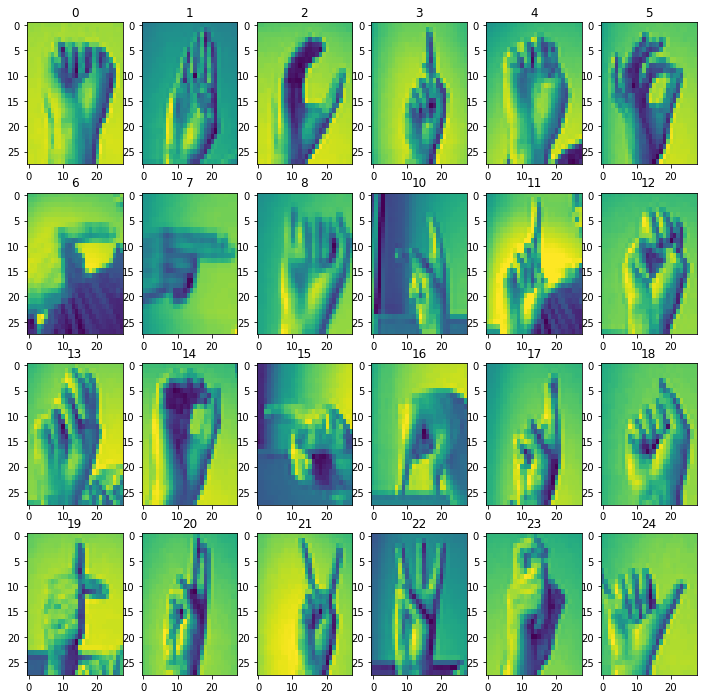

In [36]:
#Plotting every label with the corresponding sign

letters = np.sort(train['label'].unique())
fig, ax = plt.subplots(4,6,figsize=(12,12)) # make a figure 

j = 0 
k = 0
for i in letters:
    
    sign = train[train['label'] == i].drop(['label'],axis=1).reset_index(drop=True) 

    img = sign.iloc[i].to_numpy().reshape(28,28) # reshape to plot the image 

    ax[j,k].imshow(img,aspect='auto')
    ax[j,k].set_title('{}'.format(i))
    
    k += 1
    if k == 6:
        k = 0
        j += 1


The outputs are labeled by numbers between 0 and 24, except for number 9 and 25 which were skipped because letter J and Z need movement to be represented, so they are omitted, but we are able to work with it in mind. Each number represents a letter of the alphabet in the respective order, i.e, 0 is for A, 1 is for B, and so on, until 24 is for Y. 

# Split the data into train and test 

In [37]:
#Import neccesary libraries for the construction of our Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow import one_hot
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

In [38]:
#Handling arrays and one-hot encoding
from sklearn.preprocessing import LabelBinarizer
y_train = train[['label']]
y_test = test[['label']].to_numpy()

label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train) #One-hot encoding

X_train = train.drop(['label'], axis=1).to_numpy() #Features into numpy arrays 


X_test = test.drop(['label'], axis=1).to_numpy() #Features into numpy arrays 


# Rescale the pixel values in grayscale 
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = X_train.reshape(-1,28,28,1) #(batch size, height, width, depth), for grayscale depth is evidently 1
X_test = X_test.reshape(-1,28,28,1) #The batch size defines the number of samples that will be propagated through the network, in this case all the samples.

np.shape(y_train)

(27455, 24)

#Data Augmentation

In [39]:
#Using Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    zoom_range=0.1,
    validation_split=0.1,)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)

datagen.fit(X_train)
train_aug=datagen.flow(X_train, y_train, batch_size=128, subset='training',shuffle=True)
valid_aug=datagen.flow(X_train, y_train, batch_size=128, subset='validation',shuffle=True)

#Some artificial images generated

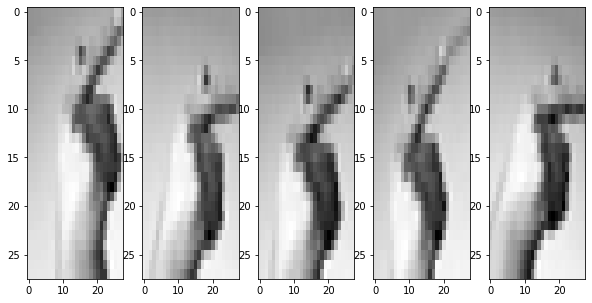

In [40]:
#Plotting some artificial images generated with the Data Augmentation
def plot_images(rows,cols,sample_img_array):
    fig,axes=plt.subplots(rows,
                          cols,
                          figsize=(10,5))
    for img,ax in zip(sample_img_array,axes):
        ax.imshow(img.reshape(28,28),aspect='auto',cmap="gray")
    plt.show()

augmented_images = [train_aug[0][0][3] for i in range(5)]
plot_images(1,5,augmented_images)

# Training the model

In [41]:
#callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3) #Early stop
my_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Proyecto_CNN_SignLanguage/SignLanguage_CNN.h5',
                           save_weights_only=False,
                           frequency='epoch',
                           verbose=1)


In [42]:
#Built Neural Network
def get_model(input_shape,wd,drate):
    model = Sequential([InputLayer(input_shape=input_shape), #Input Layer
                        Conv2D(filters=128,  kernel_size=(3, 3), padding="same", activation='relu', name='conv_1'), #Convolutional Layer
                        Dropout(drate), #Dropout Regularization Layer
                        MaxPooling2D(pool_size=(2, 2), name='pool_1'), #MaxPooling Layer
                        Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', name='conv_2'), #Convolutional Layer
                        MaxPooling2D(pool_size=(2, 2), name='pool_2'), #MaxPooling Layer
                        Flatten(name='flatten'),  #Flatten layer
                        Dense(units=512, activation='relu', name='dense_1'), #Dense layer with ReLU Activation function
                        Dropout(drate), #Dropout Regularization Layer
                        Dense(units=24, activation='softmax', name='dense_2')]) #Dense layer with softmax Activation function
    
    return model

In [43]:
#Compile the model using optimizer adam, categorical_crossentropy loss function and Accuracy as the Metric
def compile_model(model):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
#Function to test model accuracy

def get_test_accuracy(model, x_test, y_test):
    y_test = label_binarizer.fit_transform(y_test)# One-hot encoding
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('Accuracy: {acc:0.3f}'.format(acc=test_acc))

In [45]:
#Create an instance of the model and show model summary
model=get_model(X_train[0].shape,1e-3,0.5)
compile_model(model)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 dropout_4 (Dropout)         (None, 28, 28, 128)       0         
                                                                 
 pool_1 (MaxPooling2D)       (None, 14, 14, 128)       0         
                                                                 
 conv_2 (Conv2D)             (None, 14, 14, 64)        73792     
                                                                 
 pool_2 (MaxPooling2D)       (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense_1 (Dense)             (None, 512)              

In [46]:
# Fit model, with simple checkpoint which saves (and overwrites) model weights every epoch
epochs=20
history=model.fit(train_aug,epochs=epochs,validation_data=valid_aug,verbose=1, callbacks = [es,my_checkpoint])

Epoch 1/20
194/194 [==============================] - ETA: 0s - loss: 2.4168 - accuracy: 0.2637
Epoch 1: saving model to /content/drive/MyDrive/Proyecto_CNN_SignLanguage/SignLanguage_CNN.h5
194/194 [==============================] - 121s 621ms/step - loss: 2.4168 - accuracy: 0.2637 - val_loss: 1.7822 - val_accuracy: 0.5344
Epoch 2/20
194/194 [==============================] - ETA: 0s - loss: 1.3092 - accuracy: 0.5728
Epoch 2: saving model to /content/drive/MyDrive/Proyecto_CNN_SignLanguage/SignLanguage_CNN.h5
194/194 [==============================] - 121s 624ms/step - loss: 1.3092 - accuracy: 0.5728 - val_loss: 1.1852 - val_accuracy: 0.7308
Epoch 3/20
194/194 [==============================] - ETA: 0s - loss: 0.8524 - accuracy: 0.7178
Epoch 3: saving model to /content/drive/MyDrive/Proyecto_CNN_SignLanguage/SignLanguage_CNN.h5
194/194 [==============================] - 121s 623ms/step - loss: 0.8524 - accuracy: 0.7178 - val_loss: 0.7760 - val_accuracy: 0.8536
Epoch 4/20
194/194 [=====

In this case the model train untill all the 20 epochs, that means Early Stopping didn't happened.

#Evaluating the model

Accuracy: 0.990


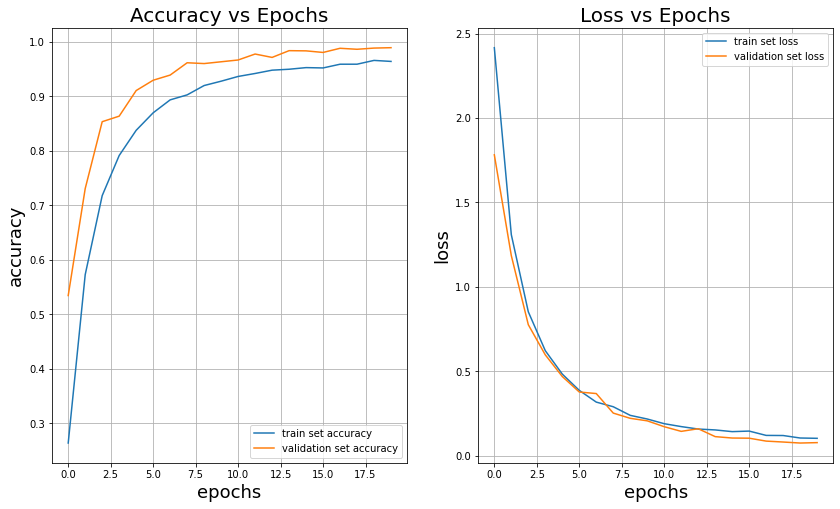

In [47]:
#Evaluate the model using the Accuracy metric

#xvals=range(es.stopped_epoch)
fig,ax=plt.subplots(1,2,figsize=(14,8))
ax[0].plot(history.history['accuracy'],label='train set accuracy')
ax[0].plot(history.history['val_accuracy'],label='validation set accuracy')
ax[0].set_title('Accuracy vs Epochs', fontsize=20)
ax[0].set_xlabel('epochs', fontsize=18)
ax[0].set_ylabel('accuracy', fontsize=18)
ax[0].legend()
ax[0].grid()

ax[1].plot(history.history['loss'],label='train set loss')
ax[1].plot(history.history['val_loss'],label='validation set loss')
ax[1].set_title('Loss vs Epochs', fontsize=20)
ax[1].set_xlabel('epochs', fontsize=18)
ax[1].set_ylabel('loss', fontsize=18)
ax[1].legend()
ax[1].grid()

get_test_accuracy(model,X_test,y_test)

#Prediction labels from ten random images

In [48]:
#Loading the model from the .h5 file saved (our model)
from tensorflow.keras.models import load_model
model_loaded = load_model('/content/drive/MyDrive/Proyecto_CNN_SignLanguage/SignLanguage_CNN.h5')


Prediction of a letter of the model


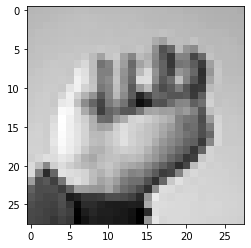


Predicted =  N

True value:  N

---------------------------------------

Prediction of a letter of the model


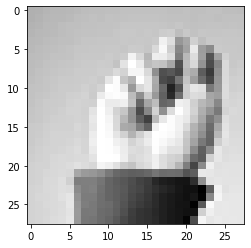


Predicted =  N

True value:  N

---------------------------------------

Prediction of a letter of the model


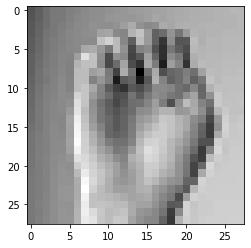


Predicted =  E

True value:  E

---------------------------------------

Prediction of a letter of the model


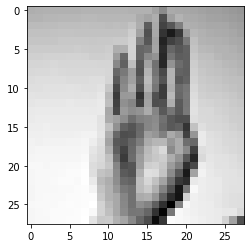


Predicted =  B

True value:  B

---------------------------------------

Prediction of a letter of the model


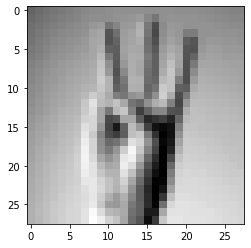


Predicted =  W

True value:  W

---------------------------------------

Prediction of a letter of the model


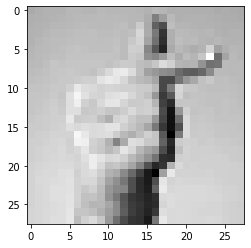


Predicted =  T

True value:  T

---------------------------------------

Prediction of a letter of the model


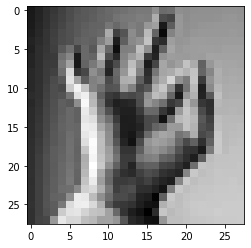


Predicted =  F

True value:  F

---------------------------------------

Prediction of a letter of the model


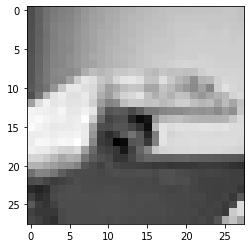


Predicted =  H

True value:  H

---------------------------------------

Prediction of a letter of the model


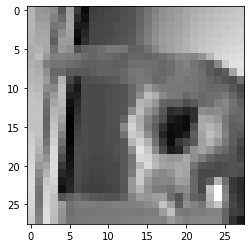


Predicted =  P

True value:  P

---------------------------------------

Prediction of a letter of the model


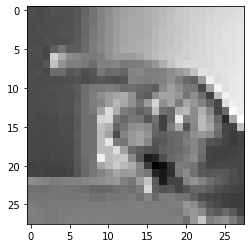


Predicted =  P

True value:  P

---------------------------------------


In [49]:
#Dictionary with the number and the corresponding letter 
letters_nums = {0:"A", 1:"B", 2:"C", 3:"D", 4:"E", 5:"F", 6:"G", 7:"H", 8:"I", 10:"K", 11:"L", 12:"M"
                , 13:"N", 14:"O", 15:"P", 16:"Q", 17:"R", 18:"S", 19:"T", 20:"U", 21:"V", 22:"W", 23:"X", 24:"Y"}

test_digits = np.random.randint(2000,size = 10) #10 random numbers lower than 2000

#Predict the corresponding value and plot the result
#With the Predicted Value and the True Value
pred = model_loaded.predict(X_test)

predict_classes=np.argmax(pred,axis=1)

#Skip the number 9
for i in test_digits:
    if(predict_classes[i] >= 9):
      predict_classes[i] += 1

    print("\nPrediction of a letter of the model")
    plt.imshow(X_test[i].reshape(28,28), cmap="gray", interpolation='none')
    plt.show()
    print('\nPredicted = ', letters_nums[ predict_classes[i] ])

    print("\nTrue value: ", letters_nums[ y_test[i][0] ])
    print("\n---------------------------------------")

# Prediction labels for signs taken by ourselves

In [50]:
#Location of the images
!ls drive/MyDrive/Proyecto_CNN_SignLanguage/TestImgs

imag_10.jpg  imag_13.jpg  imag_16.jpg  imag_2.jpg  imag_5.jpg  imag_8.jpg
imag_11.jpg  imag_14.jpg  imag_17.jpg  imag_3.jpg  imag_6.jpg  imag_9.jpg
imag_12.jpg  imag_15.jpg  imag_1.jpg   imag_4.jpg  imag_7.jpg


In [51]:
#Using the model to evaluate pictures from us

from PIL import Image #Image control

#True labels of the images taken by ourselves
true_labels = [5, 5, 14, 14, 18, 18, 22, 22, 22, 24, 24, 24, 24, 1, 3, 18, 11]

images = []

#Create the list containing all converted, resized, normalized and reshaped images into a numpy array
for i in range(1,18):
   images.append( (np.array(Image.open(f"drive/MyDrive/Proyecto_CNN_SignLanguage/TestImgs/imag_{i}.jpg").convert('L').resize((28, 28)))/255.0 ).reshape(-1,28,28,1))

len(images)

17


Prediction of a letter of the model


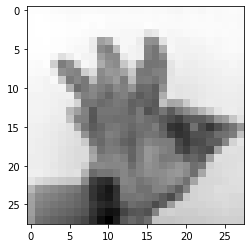


Predicted =  T

True value:  F
------------------------------

Prediction of a letter of the model


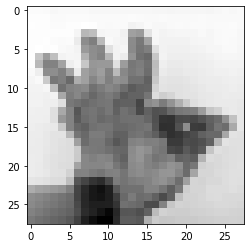


Predicted =  T

True value:  F
------------------------------

Prediction of a letter of the model


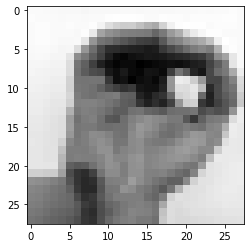


Predicted =  O

True value:  O
------------------------------

Prediction of a letter of the model


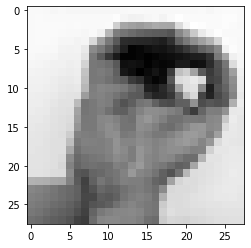


Predicted =  O

True value:  O
------------------------------

Prediction of a letter of the model


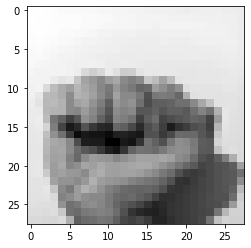


Predicted =  P

True value:  S
------------------------------

Prediction of a letter of the model


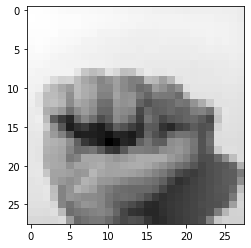


Predicted =  P

True value:  S
------------------------------

Prediction of a letter of the model


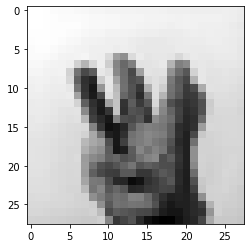


Predicted =  N

True value:  W
------------------------------

Prediction of a letter of the model


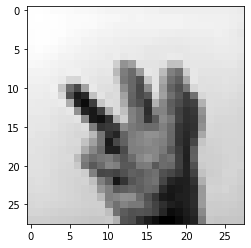


Predicted =  N

True value:  W
------------------------------

Prediction of a letter of the model


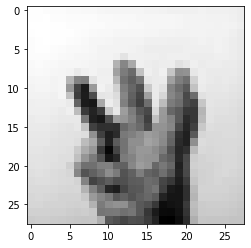


Predicted =  N

True value:  W
------------------------------

Prediction of a letter of the model


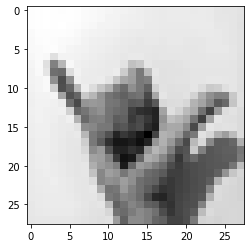


Predicted =  Y

True value:  Y
------------------------------

Prediction of a letter of the model


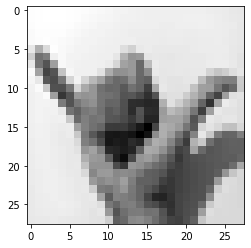


Predicted =  Y

True value:  Y
------------------------------

Prediction of a letter of the model


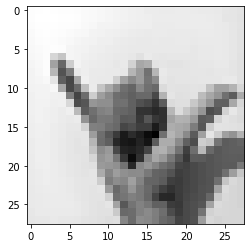


Predicted =  Y

True value:  Y
------------------------------

Prediction of a letter of the model


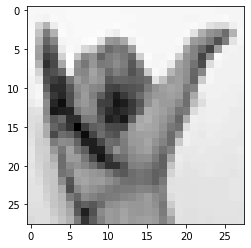


Predicted =  Y

True value:  Y
------------------------------

Prediction of a letter of the model


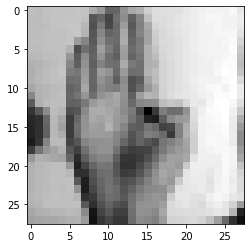


Predicted =  P

True value:  B
------------------------------

Prediction of a letter of the model


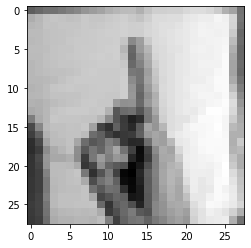


Predicted =  D

True value:  D
------------------------------

Prediction of a letter of the model


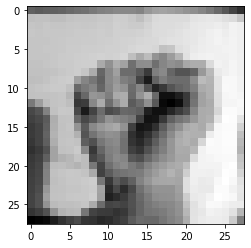


Predicted =  A

True value:  S
------------------------------

Prediction of a letter of the model


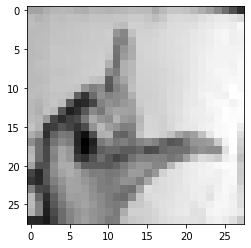


Predicted =  L

True value:  L
------------------------------


In [52]:
#Predicting the labels with our model

predictions = []

for i in range(0,17):
  pred = model_loaded.predict(images[i])
  predict_classes=np.argmax(pred,axis=1) 

  if(predict_classes >= 9):
    predict_classes += 1

  predictions.append(predict_classes)

  print("\nPrediction of a letter of the model")
  plt.imshow(images[i].reshape(28,28), cmap="gray", interpolation='none')
  plt.show()
  print('\nPredicted = ', letters_nums[ predict_classes[0] ])

  print("\nTrue value: ", letters_nums[ true_labels[i] ])
  print("------------------------------")


## Results and conclusions
We built a Convolutional Neural Network Model to classify signs from sign language. The model has a very good accuracy of: 0.9894 (99%). We tested the model with the test dataset and it worked very well, we got an accuracy about: 0.990 (99%) and finally, we used the model to classify images of sign language taken by ourselves, and it turns out that the model failed a couple of times maybe because the images we took had some problems like some shadows, lot of pixels, among others. But in the majority of the images, we obtained the correct result.